**Note:** Mac users may have issues using the fugashi package and will recieve TLS errors. We solved this be running the code on Colab or a windows machine.

You can do that easily by cloning the repo

In [ ]:
!git clone https://github.com/christianjensen2903/QuestionAnswering
%cd /content/QuestionAnswering

In [1]:
%pip install requirements.txt

HINT: You are attempting to install a package literally named "requirements.txt" (which cannot exist). Consider using the '-r' flag to install the packages listed in requirements.txtNote: you may need to restart the kernel to use updated packages.



ERROR: Could not find a version that satisfies the requirement requirements.txt (from versions: none)
ERROR: No matching distribution found for requirements.txt


In [2]:
from models.Model import Model
from models.Logistic.BOWLogistic import BOWLogistic
from models.MLP.BOWMLP import BOWMLP
from models.MLP.CBOW_BOWMLP import CBOW_BOWMLP
from models.MLP.CBOWMLP import CBOWMLP
from models.RandomForest.BOWRandomForest import BOWRandomForest
from models.RandomForest.CBOW_BOWRandomForest import CBOW_BOWRandomForest
from models.RandomForest.CBOWRandomForest import CBOWRandomForest
from models.Logistic.CBOW_BOWLogistic import CBOW_BOWLogistic
from models.Logistic.CBOWLogistic import CBOWLogistic
from models.Logistic.MultiGPT2Logistic import MultiGPT2Logistic
from models.Logistic.GPT2Logistic import GPT2Logistic
from models.XGBoost.BOWXGBoost import BOWXGBoost
from models.XGBoost.CBOW_BOWXGBoost import CBOW_BOWXGBoost
from models.XGBoost.CBOWXGBoost import CBOWXGBoost
from models.GPT2Generator import GPT2Generator

from models.SequenceLabeller_BiLSTM_CRF import SequenceLabeller_BiLSTM_CRF
from models.SequenceLabeller_BiLSTM_CRF_Beam import SequenceLabeller_BiLSTM_CRF_Beam
from models.SequenceLabeller_BERT import SequenceLabeller_BERT


from languages.LanguageModel import LanguageModel
from DataExploration import DataExploration
from languages.Japanese import Japanese
from languages.English import English
from languages.Finnish import Finnish
from Preprocess import Preprocess
from Pipeline import Pipeline
from typing import List
import torch
import datasets
import pandas as pd
import random
import numpy as np
import transformers

In [3]:
# Download word_vectors
!mkdir word_vectors
%cd word_vectors
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ja.300.vec.gz
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fi.300.vec.gz

!gzip -d cc.en.300.vec.gz
!gzip -d cc.ja.300.vec.gz
!gzip -d cc.fi.300.vec.gz

%cd ..

c:\Users\chris\OneDrive\Dokumenter\GitHub\NLP-2022\word_vectors


A subdirectory or file word_vectors already exists.
'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.
'gzip' is not recognized as an internal or external command,
operable program or batch file.
'gzip' is not recognized as an internal or external command,
operable program or batch file.


c:\Users\chris\OneDrive\Dokumenter\GitHub\NLP-2022


'gzip' is not recognized as an internal or external command,
operable program or batch file.


In [4]:
import os
os.environ['WANDB_DISABLED'] = 'true'

In [5]:
def enforce_reproducibility(seed=42):
    # Sets seed manually for both CPU and CUDA
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # For atomic operations there is currently 
    # no simple way to enforce determinism, as
    # the order of parallel operations is not known.
    # CUDNN
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # System based
    random.seed(seed)
    np.random.seed(seed)

enforce_reproducibility()

In [6]:
# Is used to minimize the clutter in the console
datasets.logging.set_verbosity_error()

# Define the languages to be used
languages: List[LanguageModel] = [
    English(),
    Finnish(),
    Japanese()
]


torch.cuda.empty_cache()

In [7]:
def print_headline(language: str):
    print(f'\n\n--- Language: {language} ---')

# Preprocessing and Dataset Analysis

In [8]:
all_data = {}

for language in languages:
    pipeline = Pipeline()

    # Get the preprocessed data and split it into training and validation data
    preprocessor = Preprocess(language.tokenize, language.clean)
    data = pipeline.get_data(language=language.name, preproccesor=preprocessor)
    train_data, validation_data = pipeline.split_data(data)

    all_data[language.name] = {
        "train_data": train_data,
        "validation_data": validation_data
    }


Loading data...

Loading data...

Loading data...


In [9]:
# Explore the data for each language
for language in languages:
    print_headline(language.name)
    data_exploration = DataExploration(all_data[language.name]["train_data"])
    data_exploration.find_frequent_words()



--- Language: english ---

Most frequent first words:
[('When', 1999, 0.29835820895522386), ('What', 1977, 0.29507462686567165), ('How', 1182, 0.1764179104477612), ('Who', 930, 0.13880597014925372), ('Where', 416, 0.06208955223880597)]
Most frequent last words:
[('?', 6693, 0.998955223880597), ('zombie', 2, 0.00029850746268656717), ('metabolite', 2, 0.00029850746268656717), ('BCE', 2, 0.00029850746268656717), ('\\', 1, 0.00014925373134328358)]



--- Language: finnish ---

Most frequent first words:
[('Milloin', 3234, 0.2628840838887986), ('Mikä', 2059, 0.167371159161112), ('Missä', 1474, 0.11981791578605105), ('Kuka', 1418, 0.11526581043732727), ('Mitä', 954, 0.07754836611933019)]
Most frequent last words:
[('?', 12290, 0.999024548853845), ('tulitaistelussa', 2, 0.00016257519102584944), ('syntynyt', 2, 0.00016257519102584944), ('pinta-ala', 2, 0.00016257519102584944), ('lintulaji', 2, 0.00016257519102584944)]



--- Language: japanese ---

Most frequent first words:
[('日本', 326, 0.0

# Binary Question Classification
Binary classfiers that only takes features based on the question, context document and combinations of the two

In [10]:
feature_based_classifiers = [
    BOWRandomForest(),
    BOWMLP(),
    BOWLogistic(),
    BOWXGBoost()
]

for language in languages:
    print_headline(language.name)
    
    for classifier in feature_based_classifiers:
        print(f'--- Classifier: {classifier.__class__.__name__} ---')
        classifier.set_language(language.name)
        train_data = all_data[language.name]["train_data"]
        validation_data = all_data[language.name]["validation_data"]

        pipeline = Pipeline()
        pipeline.train(
            model=classifier,
            X=classifier.extract_X(train_data),
            y=classifier.extract_y(train_data)
        )
        classifier.save()

        pipeline.evaluate(
            model=classifier,
            X=classifier.extract_X(validation_data),
            y=classifier.extract_y(validation_data)
        )



--- Language: english ---
--- Classifier: BOWRandomForest ---
Training the model...


KeyboardInterrupt: 

# Representation Learning
Extension of our binary question classifers to also include features based on continous vector representations

In [ ]:
feature_based_classifiers = [
  CBOW_BOWRandomForest(),
  CBOW_BOWMLP(),
  CBOW_BOWLogistic(),
  CBOW_BOWXGBoost()
]

for language in languages:
    print_headline(language.name)
    
    for classifier in feature_based_classifiers:
        print(f'--- Classifier: {classifier.__class__.__name__} ---')
        classifier.set_language(language.name)
        train_data = all_data[language.name]["train_data"]
        validation_data = all_data[language.name]["validation_data"]

        pipeline = Pipeline()
        pipeline.train(
            model=classifier,
            X=classifier.extract_X(train_data),
            y=classifier.extract_y(train_data)
        )
        classifier.save()

        pipeline.evaluate(
            model=classifier,
            X=classifier.extract_X(validation_data),
            y=classifier.extract_y(validation_data)
        )

We also test how the performance if only the continous representations was to be used

In [ ]:
continous_based_classifiers = [
    CBOWRandomForest(),
    CBOWMLP(),
    CBOWLogistic(),
    CBOWXGBoost()
]

for language in languages:
    print_headline(language.name)
    
    for classifier in continous_based_classifiers:
        print(f'--- Classifier: {classifier.__class__.__name__} ---')
        classifier.set_language(language.name)
        train_data = all_data[language.name]["train_data"]
        validation_data = all_data[language.name]["validation_data"]

        pipeline = Pipeline()
        pipeline.train(
            model=classifier,
            X=classifier.extract_X(train_data),
            y=classifier.extract_y(train_data)
        )
        classifier.save()

        pipeline.evaluate(
            model=classifier,
            X=classifier.extract_X(validation_data),
            y=classifier.extract_y(validation_data)
        )

# Language modelling
Extension to the classifiers in which word/sentence representations are instead extracted from neural language models

In [ ]:
classifier = GPT2Logistic()

for language in languages:
    print_headline(language.name)
    classifier.set_language(language.name)

    train_data = all_data[language.name]["train_data"]
    validation_data = all_data[language.name]["validation_data"]

    pipeline = Pipeline()
    pipeline.train(
        model=classifier,
        X=classifier.extract_X(train_data),
        y=classifier.extract_y(train_data)
    )
    classifier.save()

    pipeline.evaluate(
        model=classifier,
        X=classifier.extract_X(validation_data),
        y=classifier.extract_y(validation_data)
    )

We try to sample from these language models to see what kinds of sentences they generate. Moreover we measure the performance on the TyDi QA validation data with a commonly used language model evaluations metric

In [ ]:
question_beginning = {
    'english': ['Question: When', 'Question: What', 'Question: How'],
    'finnish': ['Question: Milloin', 'Question: Mikä', 'Question: Missä'],
    'japanese': ['Question: 日本', 'Question: 『', 'Question: アメリカ']
}
model = GPT2Generator()

for language in languages:
    print_headline(language.name)
    model.set_language(language.name)

    validation_data = all_data[language.name]["validation_data"]

    for starting_word in question_beginning[language.name]:
        model.generate_text(starting_word)

    X_validation = model.extract_X(validation_data)
    print(f'Perplexity: {model.get_perplexity(X_validation)}')

# Error Analysis and Interpretability

First we load the trained models and then we run the explainability method for that nodel

2022-11-04 15:33:31,455 | INFO | utils.py:482 | load | loading Word2Vec object from saved_models\Word2Vec\english.model
2022-11-04 15:33:31,480 | INFO | utils.py:516 | _load_specials | loading wv recursively from saved_models\Word2Vec\english.model.wv.* with mmap=None
2022-11-04 15:33:31,481 | INFO | utils.py:554 | _load_specials | setting ignored attribute cum_table to None
2022-11-04 15:33:31,862 | INFO | utils.py:448 | add_lifecycle_event | Word2Vec lifecycle event {'fname': 'saved_models\\Word2Vec\\english.model', 'datetime': '2022-11-04T15:33:31.862293', 'gensim': '4.2.0', 'python': '3.10.7 (tags/v3.10.7:6cc6b13, Sep  5 2022, 14:08:36) [MSC v.1933 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'loaded'}


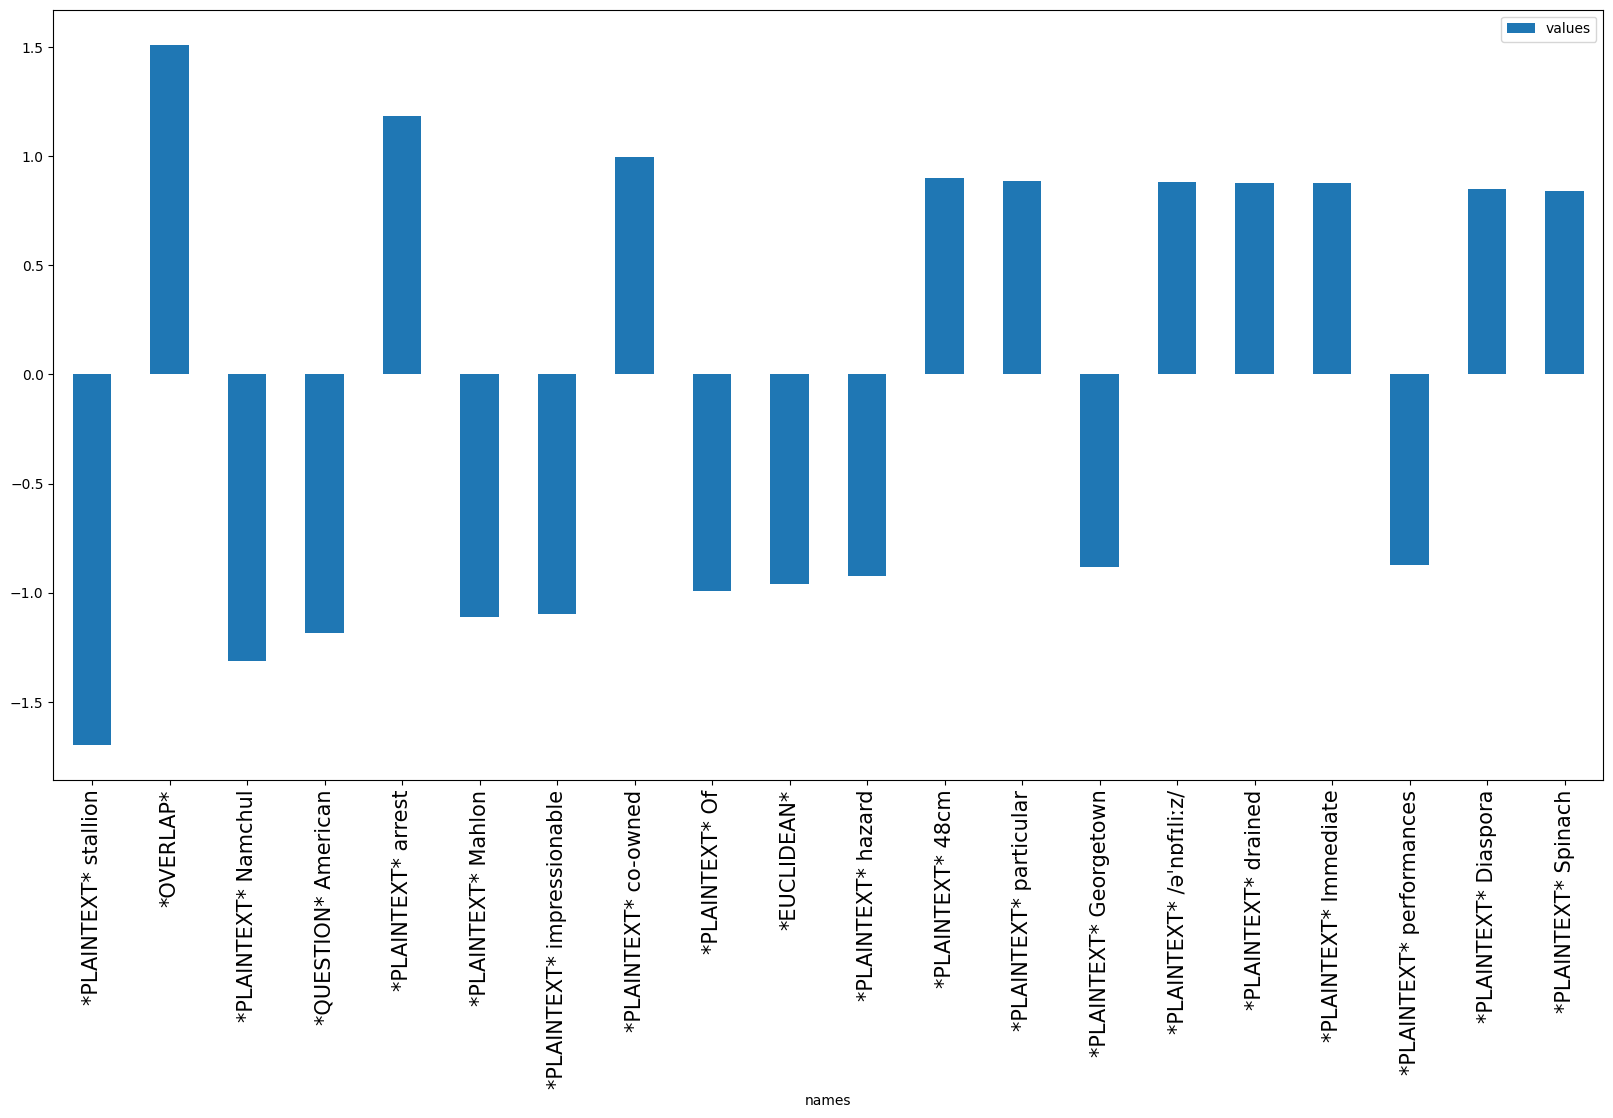

EXPLAINABILITY:
 Top 20 weights for positive:
 [('*OVERLAP*', 1.5123804916554298), ('*PLAINTEXT* arrest', 1.1830470074628032), ('*PLAINTEXT* co-owned', 0.9967589546605589), ('*PLAINTEXT* 48cm', 0.9023758952952895), ('*PLAINTEXT* particular', 0.88590789098651), ('*PLAINTEXT* /əˈnɒfɪliːz/', 0.8810205092786663), ('*PLAINTEXT* drained', 0.8766445652685115), ('*PLAINTEXT* Immediate', 0.876418682447206), ('*PLAINTEXT* Diaspora', 0.8490658238186085), ('*PLAINTEXT* Spinach', 0.8411424822284721), ('*PLAINTEXT* then-party', 0.839326173120248), ('*PLAINTEXT* homeplace', 0.8228575614808137), ('*PLAINTEXT* Starret', 0.8119963598899375), ('*PLAINTEXT* unafraid', 0.81182713209429), ('*PLAINTEXT* demographer', 0.7887796878588454), ('*PLAINTEXT* aeroplanes', 0.7786378928577088), ('*PLAINTEXT* columnist', 0.7756426163953827), ('*PLAINTEXT* 1560', 0.7750425745172903), ('*PLAINTEXT* al-qaly', 0.7721470421500587), ('*PLAINTEXT* exothermic', 0.7572779960420467)] 

 Top 20 weights for negative:
 [('*PLAINTEX

ValueError: X has 28774 features, but LogisticRegression is expecting 67033 features as input.

In [11]:
models = [
  CBOW_BOWLogistic(),
  CBOW_BOWRandomForest()
]

for model in models:
  if type(model) == CBOW_BOWLogistic:
    language = English()
  else:
    language = Finnish()
  model.set_language(language.name)
  X=model.extract_X(validation_data)
  y=model.extract_y(validation_data)
  model.load()
  model.explainability(X,y,n=20)

## Adverserial

In [ ]:
language = English()
pipeline = Pipeline()


preprocessor = Preprocess(language.tokenize, language.clean)
preprocessor.from_datasets = False

raw_adversarial_data = {
  "question_text": [
    "When was Queen Elizabeth II born?",
    "What is an uncastrated male horse called",
    "How can fast does the earth spin around its own axis"
  ],
  "document_plaintext": [
    "Queen Elizabeth II was the queen of England from 1952 until she died on the 8th of september 2022." ,
    "A horse of masculine gneder which has not been castrated can be referred to as a stallion in American English" ,
    "Earth earth earth earth spin spin spin spin around around around around"
  ]
}
dataset = pd.DataFrame.from_dict(data = raw_adversarial_data)
data = preprocessor.preprocess(dataset)


models = [
  CBOW_BOWLogistic(),
  CBOW_BOWRandomForest()
]
for model in models:
  model.set_language(language.name)
  model.load()

  X_validation = model.extract_X(data)
  y_validation = [0,1,0]

  pipeline.evaluate(
              model,
              X_validation,
              y_validation
          )

  print(model.predict(X_validation))

# Sequence Labelling
We implement a sequence labeller, which predicts which parts of a paragraph are likel part of the answer to the corresponding question

In [ ]:
config = {
    'num_train_epochs': 10,
    'learning_rate': 2e-5,
    'per_device_train_batch_size': 8,
    'per_device_eval_batch_size': 8,
    'warmup_steps': 200,
    'weight_decay': 0.01,
    'lstm_dim': 128,
    'dropout_prob': 0.1,
    'n_workers': 0,
    'beam_size': 2,
}

In [ ]:
for language in languages:
    print_headline(language.name)

    sequence_labellers = [
        SequenceLabeller_BERT(language.name, config),
        SequenceLabeller_BiLSTM_CRF(language.name, config),
    ]

    for sequence_labeller in sequence_labellers:
        print(f'--- Sequence Labeller: {sequence_labeller.__class__.__name__} ---')
        train_data = all_data[language.name]["train_data"]
        validation_data = all_data[language.name]["validation_data"]

        pipeline = Pipeline()
        pipeline.train(
            model=sequence_labeller,
            X=sequence_labeller.extract_X(train_data),
            y=sequence_labeller.extract_y(train_data)
        )

        pipeline.evaluate(
            model=sequence_labeller,
            X=sequence_labeller.extract_X(validation_data),
            y=sequence_labeller.extract_y(validation_data)
        )
        sequence_labeller.save()

We add an extension to the sequence labeller which uses beam search to select the optimal sequence of labels for the location of the answer in the text. Analyse how the performance of this system differs with beam search.

In [ ]:
for language in languages:
    print_headline(language.name)

    sequence_labeller = SequenceLabeller_BiLSTM_CRF_Beam(language.name, config)

    train_data = all_data[language.name]["train_data"]
    validation_data = all_data[language.name]["validation_data"]

    pipeline = Pipeline()
    pipeline.train(
        model=sequence_labeller,
        X=sequence_labeller.extract_X(train_data),
        y=sequence_labeller.extract_y(train_data)
    )

    num_beams = [1, 2, 3]

    for beam in num_beams:
        sequence_labeller.beam_size = beam
        pipeline.evaluate(
            model=sequence_labeller,
            X=sequence_labeller.extract_X(validation_data),
            y=sequence_labeller.extract_y(validation_data)
        )
    
    sequence_labeller.save()

In [ ]:
# Qualitative investigation of the predicted answer spans
transformers.logging.set_verbosity_error()
sequence_labeller = SequenceLabeller_BERT('english', config)
sequence_labeller.load()

validation_data = all_data['english']["validation_data"]

for i in range(10):
    i += 10 # plus 10 due to the first 10 examples being mostly withouth answer
    row = validation_data.iloc[[i]]
    X = sequence_labeller.extract_X(row)

    predictions = sequence_labeller.predict(X)[0] # [0] because we only have one example

    predicted_answers = ['']

    for i in range(len(predictions)):

        predicted_label = predictions[i]
        if predicted_label == 'B' or predicted_label == 'I': # if the label is B or I, we add the token to the current answer
            predicted_answers[-1] += row['tokenized_plaintext'].values[0][i] + ' '

        elif predicted_label == 'O' and predicted_answers[-1] != '': # if the label is O and the current answer is not empty, we add a new answer
            predicted_answers[-1] = predicted_answers[-1][:-1] # remove trailing space
            predicted_answers.append('')

    if predicted_answers[-1] == '': # remove last empty answer
        predicted_answers = predicted_answers[:-1]


    print(f'Question: {row["question_text"].values[0]}')
    print(f'Answer: {row["answer_text"].values[0]}')
    print(f'Predicted answers: {predicted_answers}')
    print()

# Multilingual QA

We start by implementing our binary question system with a multilingual encoder instead of the monolingual ones. With this we perform zero-shot cross-lingual evaluation

In [ ]:
# Zero shot classification
model = MultiGPT2Logistic()
for train_language in languages:
    print(f'\n\n--- Training on {train_language.name} ---')
    model.set_language(train_language.name)
    
    try:
        model.load()
    except:
        train_data = all_data[train_language.name]["train_data"].head(300)
        X_train = model.extract_X(train_data)
        y_train = train_data['is_answerable']
        model = pipeline.train(
            model,
            X_train,
            y_train
        )
        model.save()
    
    for val_language in languages:
        print(f'\n\t- Validating on {val_language.name}')
        validation_data = all_data[val_language.name]["validation_data"].head(300)
        X_validation = model.extract_X(validation_data)
        y_validation = validation_data['is_answerable']
        pipeline.evaluate(
            model,
            X_validation,
            y_validation
        )

We now implement our sequence tagger with a multilingual encoding and perform zero-shot cross-lingual evaluation

In [ ]:
# Zero shot classification
for language in languages:
    print(f'\n\n--- Training on {language.name} ---')

    sequence_labeller = SequenceLabeller_BERT('multilingual', config)

    train_data = all_data[language.name]["train_data"]
    validation_data = all_data[language.name]["validation_data"]


    pipeline = Pipeline()
    pipeline.train(
        model=sequence_labeller,
        X=sequence_labeller.extract_X(train_data),
        y=sequence_labeller.extract_y(train_data)
    )

    for language in languages:
      print(f'--- Validating on {language.name} ---')
      validation_data = all_data[language.name]['validation_data']
      pipeline.evaluate(
          model=sequence_labeller,
          X=sequence_labeller.extract_X(validation_data),
          y=sequence_labeller.extract_y(validation_data)
      )
    
    sequence_labeller.save()